In [34]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

[36, 72, 144, 288]


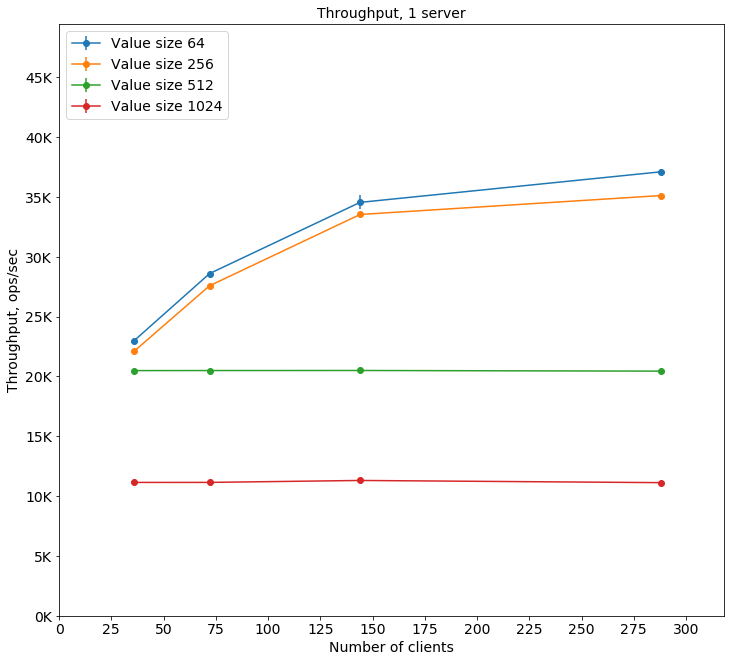

[[23000.433333333334, 28593.86666666667, 34543.26, 37098.59333333333], [22118.833333333332, 27576.146666666667, 33530.98, 35113.85333333333], [20487.033333333333, 20492.36333333333, 20496.66, 20442.88], [11144.18, 11146.303333333335, 11308.196666666669, 11125.76]]


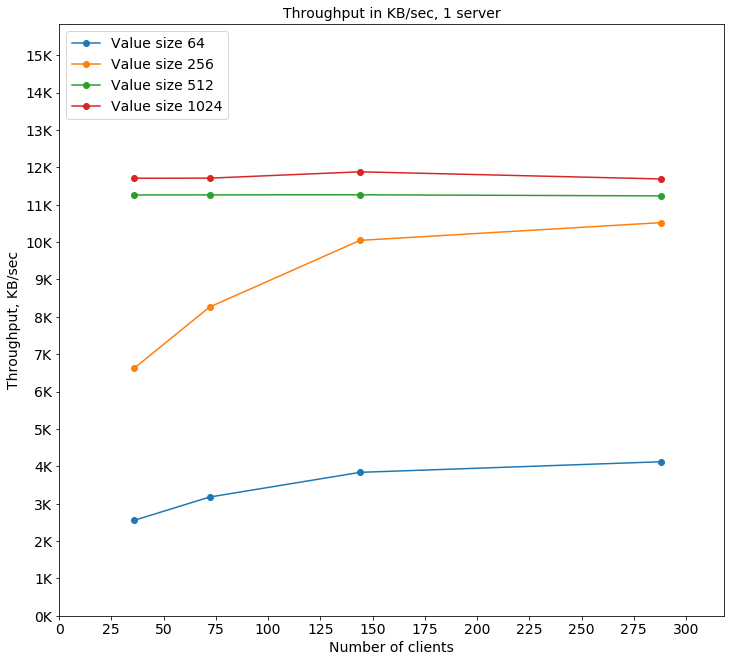

[[2555.59, 3177.16, 3838.2666666666664, 4122.023333333333], [6626.536666666667, 8261.56, 10045.589999999998, 10519.633333333333], [11259.443333333335, 11262.433333333334, 11264.716666666667, 11235.133333333333], [11707.729999999998, 11709.926666666666, 11879.96, 11688.383333333333]]


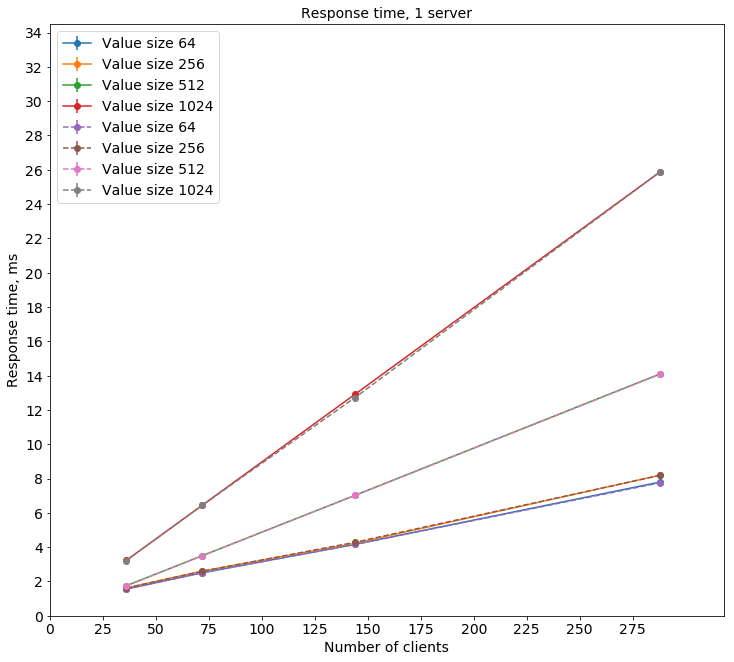

[[1.5609435592901137, 2.513978326597202, 4.1653369794959625, 7.796470989873176], [1.6230917878178868, 2.6069532142206486, 4.229987150746562, 8.19687391937567], [1.7527456206828262, 3.509617689407437, 7.022867014431932, 14.101291195010353], [3.2259479267929154, 6.455862384809758, 12.915419987355557, 25.882293848642266]]


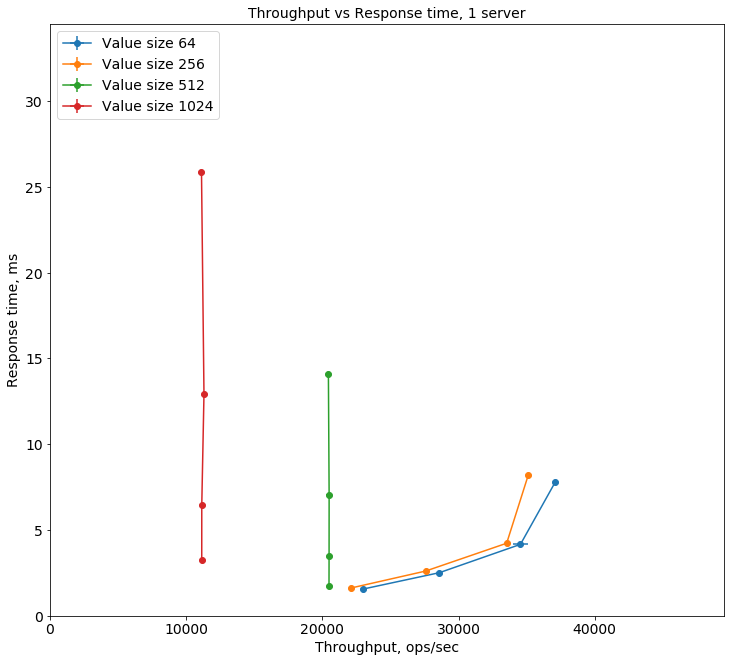

In [40]:
path_to_experiment="/home/skotti/data_from_cloud/final_ex/final_copy/part1/"
value_sizes=[64, 256, 512, 1024]
client_numbers=[4, 8, 16, 32]
repetitions = 3
memtier_instances=3
experiments=len(value_sizes)*len(client_numbers) * repetitions
prefix="/home/skotti/asl-project-2019-ruzhanskaia/report_src/part1_cl_"


import csv
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean 
import re
import numpy as np


clients_data = []

for i in range(memtier_instances):
    initial = open(path_to_experiment+"client"+str(i+1)+".log","r")
    lines = initial.readlines()
    total_ops = 0
    for line in lines:
        if line.startswith("[RUN #1 100%"):
            line = re.sub(' +', ' ', line)
            parts = line.split(' ')
            total_ops = parts[7]
        if line.startswith("Gets"):
            line = re.sub(' +', ' ', line)
            parts = line.split(' ')
            parts = [parts[1], parts[4], parts[5], total_ops]
            clients_data.append(parts) 
    initial.close()


global_data = pd.DataFrame(columns=['Value size', 'Client number', 'Repetition', 'Memtier instance', 'TR', 'RT', 'TR_B', 'Total ops'])

j = 0
k = 0
for value_size in value_sizes:
    for n in client_numbers:
        for rep in range(repetitions):
            for memtier in range(memtier_instances):
                d = [value_size, n, rep, memtier, clients_data[memtier * experiments + k][0], clients_data[memtier * experiments + k][1], clients_data[memtier * experiments + k][2], clients_data[memtier * experiments + k][3]]
                global_data.loc[j] = d
                j += 1
            k += 1

global_data['Value size'] = global_data['Value size'].astype(int)
global_data['Client number'] = global_data['Client number'].astype(int)
global_data['Repetition'] = global_data['Repetition'].astype(int)
global_data['Memtier instance'] = global_data['Memtier instance'].astype(int)
global_data['TR'] = global_data['TR'].astype(float)
global_data['RT'] = global_data['RT'].astype(float)
global_data['TR_B'] = global_data['TR_B'].astype(float)
global_data['Total ops'] = global_data['Total ops'].astype(int)

global_data['Total time'] = global_data['RT']*global_data['Total ops']

TR_graph = []
X_axis =[i * 9 for i in client_numbers]
print(X_axis)
TR_overall = []
RT_overall = []
TR_B_overall = []
RT_overall_with_formula = []
TR_error_overall = []
RT_error_overall = []
TR_B_error_overall = []

for value_size in value_sizes:
    TR = []
    RT = []
    TR_B = []
    TR_error = []
    RT_error = []
    for memtier in range(memtier_instances):
        TR_client = []
        RT_client = []
        for client_number in client_numbers:
            subset = global_data[ (global_data['Value size'] == value_size) & 
                             (global_data['Client number'] == client_number) &
                             (global_data['Memtier instance'] == memtier)]

            groupped = subset.groupby(["Repetition"]).mean()
            groupped1 = subset.groupby(["Repetition"]).mean()
            TR_client.append(groupped.mean()['TR'])
            RT_client.append(groupped.mean()['RT'])
        
        

    for client_number in client_numbers:
        subset = global_data[(global_data['Value size'] == value_size) & 
                             (global_data['Client number'] == client_number)]
        groupped = subset.groupby(['Repetition']).sum()
        TR_std = np.std(groupped['TR'].values)
        TR_error.append(TR_std)
        TR.append(float(groupped.mean()['TR']))
        
        groupped1 = subset.groupby(['Repetition']).sum()
        groupped2 = groupped1['Total time']/groupped1['Total ops']
        RT.append(float(groupped2.mean()))
        RT_std = np.std(groupped2.values)
        RT_error.append(RT_std)
        
        groupped3 = subset.groupby(['Repetition']).sum()
        TR_B.append(float(groupped3.mean()['TR_B']))
        
    TR_overall.append(TR)
    RT_overall.append(RT)
    TR_B_overall.append(TR_B)
    TR_error_overall.append(TR_error)
    RT_error_overall.append(RT_error)
    RT_overall_with_formula.append([(1/t) * 1000 * c - 0.01 for t, c in zip(TR, X_axis)])

from matplotlib.ticker import FuncFormatter
def kilo(x, pos):
    return '%1.fK' % (x*1e-3)
formatter = FuncFormatter(kilo)
plt.figure(figsize=(10, 9))
plt.axes().yaxis.set_major_formatter(formatter)
plt.title("Throughput, 1 server")
max1 = 0
for i in range(len(TR_overall)):
    plt.errorbar(X_axis, TR_overall[i],
            yerr=TR_error_overall[i],
            fmt='-o',
            label="Value size "+str(value_sizes[i]))
    max2 = max(TR_overall[i]) + max(TR_overall[i])/3
    if max2 > max1:
        max1 = max2
plt.ylim(0, max1)
plt.xlim(0, max(X_axis) + 30)
plt.xticks(np.arange(0, max(X_axis) + 30, 25))
plt.yticks(np.arange(0, max1, 5000))
plt.ylabel('Throughput, ops/sec')
plt.xlabel('Number of clients')
plt.legend(loc="upper left")
plt.tight_layout(0)
plt.savefig(prefix+"tr.pdf")
plt.show()

print(TR_overall)

plt.figure(figsize=(10, 9))
plt.axes().yaxis.set_major_formatter(formatter)
plt.title("Throughput in KB/sec, 1 server")
max1 = 0
for i in range(len(TR_B_overall)):
    plt.plot(X_axis, TR_B_overall[i], '-o',
            label="Value size "+str(value_sizes[i]))
    max2 = max(TR_B_overall[i]) + max(TR_B_overall[i])/3
    if max2 > max1:
        max1 = max2
plt.ylim(0, max1)
plt.xlim(0, max(X_axis) + 30)
plt.xticks(np.arange(0, max(X_axis) + 30, 25))
plt.yticks(np.arange(0, max1, 1000))
plt.ylabel('Throughput, KB/sec')
plt.xlabel('Number of clients')
plt.legend(loc="upper left")
plt.tight_layout(0)
plt.savefig(prefix+"tr_b.pdf") # bbox_inches = 'tight', pad_inches = 0, 
#plt.savefig(prefix+"tr.png", dpi=300)
plt.show()

print(TR_B_overall)
    
max1 = 0
plt.figure(figsize=(10, 9))
plt.title("Response time, 1 server")
for i in range(len(RT_overall)):
    plt.errorbar(X_axis, RT_overall[i],
            yerr=RT_error_overall[i],
            fmt='-o',
            label="Value size "+str(value_sizes[i]))
    max2 = max(RT_overall[i]) + max(RT_overall[i])/3
    if max2 > max1:
        max1 = max2
        
for i in range(len(RT_overall_with_formula)):
    plt.errorbar(X_axis, RT_overall_with_formula[i],
            yerr=RT_error_overall[i],
            fmt='--o',
            label="Value size "+str(value_sizes[i]))
    max2 = max(RT_overall[i]) + max(RT_overall[i])/3
    if max2 > max1:
        max1 = max2
        
plt.ylim(0, max1)
plt.xlim(0, max(X_axis) + 30)
plt.xticks(np.arange(0, max(X_axis), 25))
plt.yticks(np.arange(0, max1, 2))
plt.ylabel('Response time, ms')
plt.xlabel('Number of clients') 
plt.legend(loc="upper left")
plt.tight_layout(0)
plt.savefig(prefix+"rt.pdf")
plt.show()
print(RT_overall)


max1 = 0
plt.figure(figsize=(10, 9))
plt.title("Throughput vs Response time, 1 server")
for i in range(len(RT_overall)):
    plt.errorbar(TR_overall[i], RT_overall[i],
            xerr=TR_error_overall[i],
            yerr=RT_error_overall[i],
            fmt='-o',
            label="Value size "+str(value_sizes[i]))
    max2 = max(RT_overall[i]) + max(RT_overall[i])/3
    if max2 > max1:
        max1 = max2
tr_max = 0
for i in range(len(TR_overall)):
    max2 = max(TR_overall[i]) + max(TR_overall[i])/3
    if max2 > tr_max:
        tr_max = max2
plt.ylim(0, max1)
plt.xlim(0, tr_max)
plt.ylabel('Response time, ms')
plt.xlabel('Throughput, ops/sec') 
plt.legend(loc="upper left")
plt.tight_layout(0)
plt.savefig(prefix+"rttr.pdf")
#plt.savefig(prefix+"rttr.png", dpi=300) 
plt.show()

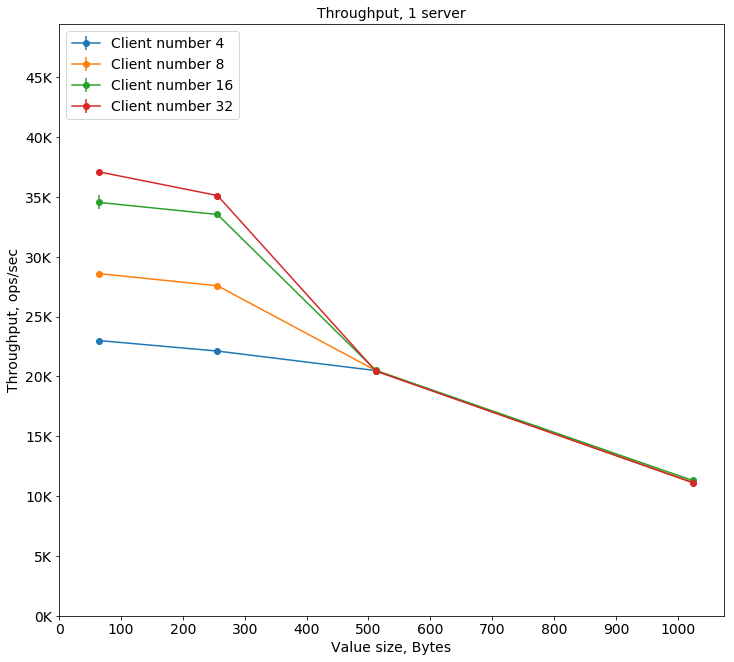

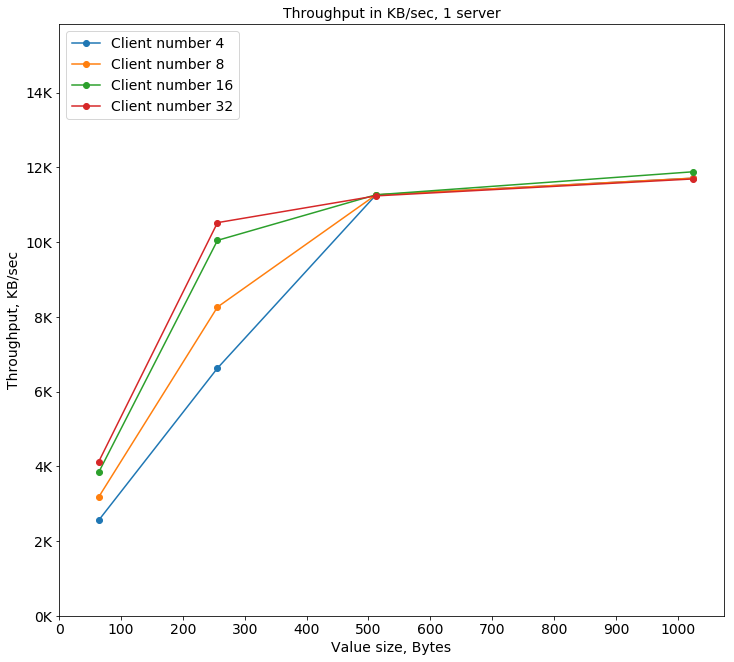

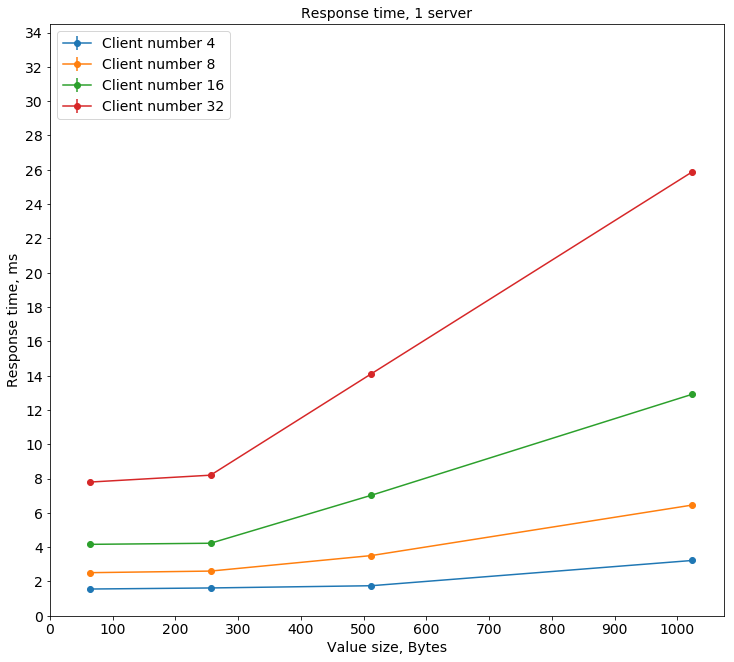

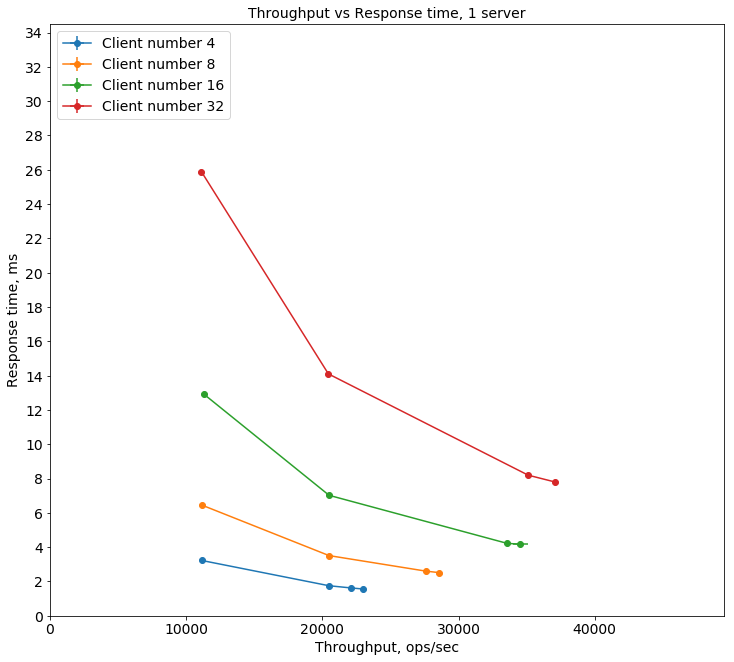

In [41]:
prefix="/home/skotti/asl-project-2019-ruzhanskaia/report_src/part1_vl_"
X_axis = value_sizes
TR_overall = []
RT_overall = []
TR_B_overall = []
RT_overall_with_formula = []
TR_error_overall = []
RT_error_overall = []

for client_number in client_numbers:
    TR = []
    RT = []
    TR_B = []
    TR_error = []
    RT_error = []
    
    for value_size in value_sizes:
        subset = global_data[(global_data['Value size'] == value_size) & 
                             (global_data['Client number'] == client_number)]
        groupped = subset.groupby(['Repetition']).sum()
        TR_std = np.std(groupped['TR'].values)
        TR_error.append(TR_std)
        TR.append(float(groupped.mean()['TR']))
        groupped1 = subset.groupby(['Repetition']).sum()
        groupped2 = groupped1['Total time']/groupped1['Total ops']
        RT.append(float(groupped2.mean()))
        RT_std = np.std(groupped2.values)
        RT_error.append(RT_std)
        
        groupped3 = subset.groupby(['Repetition']).sum()
        TR_B.append(float(groupped3.mean()['TR_B']))
        
    TR_overall.append(TR)
    RT_overall.append(RT)
    TR_B_overall.append(TR_B)
    TR_error_overall.append(TR_error)
    RT_error_overall.append(RT_error)
    RT_overall_with_formula.append([(1/t) * 1000 * c for t, c in zip(TR, X_axis)])

from matplotlib.ticker import FuncFormatter
def kilo(x, pos):
    return '%1.fK' % (x*1e-3)
formatter = FuncFormatter(kilo)
plt.figure(figsize=(10, 9))
plt.axes().yaxis.set_major_formatter(formatter)
plt.title("Throughput, 1 server")
max1 = 0
for i in range(len(TR_overall)):
    plt.errorbar(X_axis, TR_overall[i],
            yerr=TR_error_overall[i],
            fmt='-o',
            label="Client number "+str(client_numbers[i]))
    max2 = max(TR_overall[i]) + max(TR_overall[i])/3
    if max2 > max1:
        max1 = max2
plt.ylim(0, max1)
plt.xlim(0, max(X_axis) + 50)
plt.xticks(np.arange(0, max(X_axis) + 50, 100))
plt.yticks(np.arange(0, max1, 5000))
plt.ylabel('Throughput, ops/sec')
plt.xlabel('Value size, Bytes')
plt.legend(loc="upper left")
plt.tight_layout(0)
plt.savefig(prefix+"tr.pdf")
#plt.savefig(prefix+"tr.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 9))
plt.axes().yaxis.set_major_formatter(formatter)
plt.title("Throughput in KB/sec, 1 server")
max1 = 0
for i in range(len(TR_B_overall)):
    plt.plot(X_axis, TR_B_overall[i], '-o',
            label="Client number "+str(client_numbers[i]))
    max2 = max(TR_B_overall[i]) + max(TR_B_overall[i])/3
    if max2 > max1:
        max1 = max2
plt.ylim(0, max1)
plt.xlim(0, max(X_axis) + 50)
plt.xticks(np.arange(0, max(X_axis) + 50, 100))
plt.yticks(np.arange(0, max1, 2000))
plt.ylabel('Throughput, KB/sec')
plt.xlabel('Value size, Bytes')
plt.legend(loc="upper left")
plt.tight_layout(0)
plt.savefig(prefix+"tr_b.pdf") # bbox_inches = 'tight', pad_inches = 0, 
#plt.savefig(prefix+"tr.png", dpi=300)
plt.show()
    
max1 = 0
plt.figure(figsize=(10, 9))
plt.title("Response time, 1 server")
for i in range(len(RT_overall)):
    plt.errorbar(X_axis, RT_overall[i],
            yerr=RT_error_overall[i],
            fmt='-o',
            label="Client number "+str(client_numbers[i]))
    max2 = max(RT_overall[i]) + max(RT_overall[i])/3
    if max2 > max1:
        max1 = max2
        
plt.ylim(0, max1)
plt.xlim(0, max(X_axis) + 50)
plt.xticks(np.arange(0, max(X_axis) + 50, 100))
plt.yticks(np.arange(0, max1, 2))
plt.ylabel('Response time, ms')
plt.xlabel('Value size, Bytes') 
plt.legend(loc="upper left")
plt.tight_layout(0)
plt.savefig(prefix+"rt.pdf")
plt.show()


max1 = 0
plt.figure(figsize=(10, 9))
plt.title("Throughput vs Response time, 1 server")
for i in range(len(RT_overall)):
    plt.errorbar(TR_overall[i], RT_overall[i],
            xerr=TR_error_overall[i],
            yerr=RT_error_overall[i],
            fmt='-o',
            label="Client number "+str(client_numbers[i]))
    max2 = max(RT_overall[i]) + max(RT_overall[i])/3
    if max2 > max1:
        max1 = max2
tr_max = 0
for i in range(len(TR_overall)):
    max2 = max(TR_overall[i]) + max(TR_overall[i])/3
    if max2 > tr_max:
        tr_max = max2
plt.ylim(0, max1)
plt.xlim(0, tr_max)
plt.yticks(np.arange(0, max1, 2))
plt.ylabel('Response time, ms')
plt.xlabel('Throughput, ops/sec') 
plt.legend(loc="upper left")
plt.tight_layout(0)
plt.savefig(prefix+"rttr.pdf")
plt.show()